In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import os
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader
from sklearn import model_selection
import torchvision.transforms as transforms
import torchvision.io 
import librosa
from PIL import Image
import torch.multiprocessing as mp
import audiomentations
import soundfile
import time
import logging
import warnings
from time import time
from functools import wraps

warnings.filterwarnings('ignore')
logging.basicConfig(
    filename="./logs/info.log", 
    level=logging.INFO, 
    format='%(asctime)s: %(levelname)s: %(message)s', 
    datefmt='%m/%d/%Y %I:%M:%S %p'
)

logger = logging.getLogger()


In [2]:
class TransformationType:
    TORCHVISION = "torchvision"
    ALB = "albumentations"

class Models:
    RESNET34 = "resnet34"
    RESNET50 = "resnet50"
    RESNEXT50 = "resnext50_32x4d"    

class ImgStats:
    IMAGENET_MEAN = [0.485, 0.456, 0.406]
    IMAGENET_STD = [0.229, 0.224, 0.225]    

# CONSTANTS
class Config:
    W_AND_B_RUN_NAME = "full_pipeline_run_1"
    NUM_CLASSES = 5
    BATCH_SIZE = 32
    NUM_FOLDS = 5
    UNFREEZE_EPOCH_NO = 1
    NUM_EPOCHS = 1
    NUM_WORKERS = mp.cpu_count()
    INPUT_IMAGE_SIZE = (128,128)
    IMG_MEAN = ImgStats.IMAGENET_MEAN
    IMG_STD = ImgStats.IMAGENET_STD
    FAST_DEV_RUN = True
    PRECISION = 16
    DATA_ROOT_FOLDER = "./data/"
    PATIENCE = 5
    SUBSET_ROWS_FRAC = 0.1
    TRAIN_ON_SUBSET = True
    RANDOM_SEED = 42
    MODEL_TO_USE = Models.RESNET34
    # model hyperparameters
    MODEL_PARAMS = {    
        "drop_out": 0.25,
        "lr": 0.00036
    }

In [3]:
class AudioConfig:
    # settings
    # number of samples per time-step in spectrogram. Defaults to win_length / 4
    # Also the step or stride between windows. If the step is smaller than the window length, the windows will overlap
    hop_length = 512 
    # number of bins in spectrogram. Height of image
    n_mels = 128 
    # number of time-steps. Width of image
    time_steps = 512 
    # number of samples per second
    sampling_rate = 22050
    # sec
    duration = 5 
    fmin = 20
    fmax = sampling_rate // 2
    # FFT window size or length of the windowed signal after padding with zeros. Default value = 2048 ( for music signals)    
    n_fft = hop_length * 4
    # Each frame of audio is windowed by window of length win_length and then padded with zeros to match n_fft. Defaults to n_fft
    win_length = hop_length * 4    
    padmode = 'constant'
    samples = sampling_rate * duration

In [4]:
def timeit(func):
    @wraps(func)
    def wrap(*args, **kwargs):
        start = time()
        result = func(*args, **kwargs)
        end = time()
        exec_time = end - start
        logger.info(f"Executing {func} took {exec_time} seconds")
        return result
    return wrap        

In [5]:

# split the training dataframe into kfolds for cross validation. We do this before any processing is done
# on the data. We use stratified kfold if the target distribution is unbalanced
def strat_kfold_dataframe(df, target_col_name, num_folds=Config.NUM_FOLDS):
    # we create a new column called kfold and fill it with -1
    df["kfold"] = -1
    # randomize of shuffle the rows of dataframe before splitting is done
    df = df.sample(frac=1, random_state=Config.RANDOM_SEED).reset_index(drop=True)
    # get the target data
    y = df[target_col_name].values
    skf = model_selection.StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=Config.RANDOM_SEED)
    for fold, (train_index, val_index) in enumerate(skf.split(X=df, y=y)):
        df.loc[val_index, "kfold"] = fold    
    return df     

df_train = pd.read_csv(Config.DATA_ROOT_FOLDER + "train.csv")
logger.info("Loaded train data frame")
# filter out records without any corresponding mel spectrogram image
df_train["audio_exists"] = df_train.filename.map(
    lambda fp: os.path.exists(Config.DATA_ROOT_FOLDER + "train/" + fp)
)
df_train_noaudio = df_train[~df_train.audio_exists]
df_train = df_train[df_train.audio_exists]
df_train = strat_kfold_dataframe(df_train, target_col_name="genre_id")
logger.info("Peformed stratified k fold split of train data")
df_train.head()

,song_id,filename,filepath,genre_id,genre,audio_exists,kfold
0,2296,002296.ogg,train/002296.ogg,1,Rock,True,3
1,8198,008198.ogg,train/008198.ogg,17,Blues,True,2
2,17663,017663.ogg,train/017663.ogg,12,Old-Time / Historic,True,2
3,7167,007167.ogg,train/007167.ogg,9,International,True,3
4,11242,011242.ogg,train/011242.ogg,6,Chiptune / Glitch,True,3


In [6]:
# Records with no corresponding audio
df_train_noaudio

,song_id,filename,filepath,genre_id,genre,audio_exists
1359,3137,003137.ogg,train/003137.ogg,1,Rock,False
4668,11088,011088.ogg,train/011088.ogg,2,Punk,False
5150,16312,016312.ogg,train/016312.ogg,7,Instrumental,False
8764,24899,024899.ogg,train/024899.ogg,0,Electronic,False
10155,4040,004040.ogg,train/004040.ogg,4,Hip-Hop,False
10873,9963,009963.ogg,train/009963.ogg,3,Experimental,False
11386,15980,015980.ogg,train/015980.ogg,4,Hip-Hop,False
11497,22698,022698.ogg,train/022698.ogg,4,Hip-Hop,False
14377,23078,023078.ogg,train/023078.ogg,5,Folk,False
14827,17940,017940.ogg,train/017940.ogg,0,Electronic,False


In [7]:
Config.NUM_CLASSES = len(df_train.genre_id.unique())

In [8]:
def crop_or_pad(y, length, is_train=True):
    """
    Crops an array to a chosen length
    Arguments:
        y {1D np array} -- Array to crop
        length {int} -- Length of the crop
        sr {int} -- Sampling rate
    Keyword Arguments:
        train {bool} -- Whether we are at train time. If so, crop randomly, else return the beginning of y (default: {True})        
    Returns:
        1D np array -- Cropped array
    """
    # # trim silence
    # if len(y) > 0:
    #     # trim, top_db=default(60) (Below 60dB is considered silence)
    #     y, _ = librosa.effects.trim(y)
    if length > len(y):
        # if length of array is less than the length to be cropped, we need to pad 
        padding = length - len(y)    # add padding at both ends
        offset = padding // 2
        y = np.pad(y, (offset, padding - offset), AudioConfig.padmode)
    else:
        if not is_train:
            start = 0
        else:
            start = np.random.randint(len(y) - length)            
        y = y[start: start + length]
    return y.astype(np.float32)        

In [9]:
# select a random 5 second clip of audio after trimming the silence
@timeit
def read_audio(audio_path, is_train=True, is_crop_or_pad=True):    
    y, sr = soundfile.read(audio_path)
    if len(y.shape) > 1:
        y = np.mean(y, axis=1)    
    #y, sr = librosa.load(audio_path, sr=AudioConfig.sampling_rate, res_type="kaiser_fast")        
    if is_crop_or_pad:
        audio_samples_length = AudioConfig.sampling_rate * AudioConfig.duration
        y = crop_or_pad(y, audio_samples_length, is_train=is_train)
    return (y, sr)

In [10]:
def mono_to_color(X, eps=1e-6, mean=None, std=None):
    """
    Converts a one channel array to a 3 channel one in [0, 255]
    Arguments:
        X {numpy array [H x W]} -- 2D array to convert
    Keyword Arguments:
        eps {float} -- To avoid dividing by 0 (default: {1e-6})
        mean {None or np array} -- Mean for normalization (default: {None})
        std {None or np array} -- Std for normalization (default: {None})
    Returns:
        numpy array [3 x H x W] -- RGB numpy array
    """
    X = np.stack([X, X, X], axis=-1)

    # Standardize
    mean = mean or X.mean()
    std = std or X.std()
    X = (X - mean) / (std + eps)

    # Normalize to [0, 255]
    _min, _max = X.min(), X.max()

    if (_max - _min) > eps:
        V = np.clip(X, _min, _max)
        V = 255 * (V - _min) / (_max - _min)
        V = V.astype(np.uint8)
    else:
        V = np.zeros_like(X, dtype=np.uint8)

    return V

In [11]:
def normalize(image, mean=None, std=None):
    """
    Normalizes an array in [0, 255] to the format adapted to neural network
    Arguments:
        image {np array [3 x H x W]} -- [description]
    Keyword Arguments:
        mean {None or np array} -- Mean for normalization, expected of size 3 (default: {None})
        std {None or np array} -- Std for normalization, expected of size 3 (default: {None})
    Returns:
        np array [H x W x 3] -- Normalized array
    """
    image = image / 255.0
    if mean is not None and std is not None:
        image = (image - mean) / std
    return np.moveaxis(image, 2, 0).astype(np.float32)

In [12]:
@timeit
def create_mel_spec(y, sr, conf):
    """
    Computes a mel-spectrogram and puts it at decibel scale
    Arguments:
        y {np array} -- signal
        sr {int} -- audio sample rate
        conf {AudioParams} -- Parameters to use for the spectrogram. Expected to have the attributes sr, n_mels, n_fft, hop_length
    Returns:
        np array -- Mel-spectrogram
    """
    mel_s = librosa.feature.melspectrogram(
        y=y, 
        sr=sr, 
        n_mels=conf.n_mels,
        n_fft=conf.n_fft, 
        hop_length=conf.hop_length,
        fmin=conf.fmin,
        fmax=conf.fmax
    )
    # convert amplitude to decibels
    mel_s = librosa.power_to_db(mel_s, ref=np.max)        
    mel_s = mono_to_color(mel_s)
    mel_s = normalize(mel_s)            
    return mel_s 

In [13]:
from audiomentations import AddGaussianSNR, TimeStretch, PitchShift, Shift
from audiomentations import SpecChannelShuffle, SpecCompose, SpecFrequencyMask
from torchvision.transforms import Compose, RandomResizedCrop, ToPILImage

audio_transforms = audiomentations.Compose([
    AddGaussianSNR(min_snr_in_db=5, max_snr_in_db=40.0, p=0.5),
    TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5),
    PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
    Shift(min_fraction=-0.5, max_fraction=0.5, p=0.5),
])

mel_spec_transforms = audiomentations.SpecCompose([
  SpecFrequencyMask(p=0.5),
  SpecChannelShuffle(p=0.5)  
])

In [14]:
def check_negative(mel_s):
    mel_s_1d = mel_s.reshape(-1)
    neg_values = mel_s_1d[mel_s_1d < 0]
    if len(neg_values) > 0:
        return True
    else:
        return False

In [15]:
# A dataset contains the logic to fetch, load and if required transform data to bring it to a format
# that can be used by dataloaders for training. 
class AudioDataset(Dataset):
    def __init__(self, df, audio_transforms=None, melspec_transforms=None, is_train=True):
        self.df = df
        self.is_train = is_train        
        self.audio_transforms = audio_transforms
        self.melspec_transforms = melspec_transforms        

    @timeit
    def apply_audio_transforms(self, y, sr):        
        y = self.audio_transforms(samples=y, sample_rate=sr)        
        return y

    @timeit
    def apply_melspec_transforms(self, mel_s):
        mel_s = self.melspec_transforms(mel_s)        
        return mel_s

    @timeit
    def process_audio(self, index):
        logger.info(f"processing record with index={index}")
        audio_path = Config.DATA_ROOT_FOLDER + "train/" + self.df.loc[index, "filename"]
        # read in the original audio        
        result = read_audio(audio_path, is_train=self.is_train, is_crop_or_pad=True)
        y, sr = result[0], result[1]        
        # apply audio augmentations
        if self.audio_transforms is not None:
            y = self.apply_audio_transforms(y, sr)
        mel_s = create_mel_spec(y, sr, AudioConfig)
        logger.info(f"mel_s.shape = {mel_s.shape}")                
        if self.melspec_transforms is not None:
            # apply mel spectrogram augmentations
            mel_s = self.apply_melspec_transforms(mel_s)            
        # mel_s = mono_to_color(mel_s)
        # mel_s = normalize(mel_s)            
        # Resize the width of the image (dim=2 in mel spectrogram array)
        start = np.random.randint(mel_s.shape[2] - Config.INPUT_IMAGE_SIZE[1])
        mel_s = mel_s[:, :, start: start + Config.INPUT_IMAGE_SIZE[1]]
        logger.info(f"After resizing mel_s.shape = {mel_s.shape}")                                        
        target = self.df.loc[index, "genre_id"]
        song_id = self.df.loc[index, "song_id"]
        if check_negative(mel_s):
            print(f"The mel spectrogram for index={index} has negative values")
        if target < 0:
            print(f"The target = {target} for index={index} is negative")
        return song_id, mel_s, target

    def __getitem__(self, index):        
        result = self.process_audio(index)
        song_id, mel_s, target = result[0], result[1], result[2]
        return song_id, mel_s, target

    def __len__(self):
        return len(self.df)

In [16]:
def get_fold_dls(fold, df):
    df_train = df[df["kfold"] != fold].reset_index(drop=True)
    df_val = df[df["kfold"] == fold].reset_index(drop=True)    
    ds_train = AudioDataset(
        df=df_train,
        audio_transforms=audio_transforms,
        melspec_transforms=mel_spec_transforms,        
        is_train=True
    )
    ds_val = AudioDataset(
        df=df_val,
        audio_transforms=audio_transforms,
        melspec_transforms=mel_spec_transforms,        
        is_train=False
    )      
    dl_train = DataLoader(ds_train, batch_size=Config.BATCH_SIZE, shuffle=True, num_workers=Config.NUM_WORKERS)    
    dl_val = DataLoader(ds_val, batch_size=Config.BATCH_SIZE, num_workers=Config.NUM_WORKERS)
    return dl_train, dl_val, ds_train, ds_val

In [17]:
dl_train, dl_val, ds_train, ds_val = get_fold_dls(0, df_train)

In [18]:
# display images along with their labels from a batch where images are in form of numpy arrays 
# if predictions are provided along with labels, these are displayed too
def show_batch(img_ds, num_items, num_rows, num_cols, predict_arr=None):
    fig = plt.figure(figsize=(12, 6))    
    img_index = np.random.randint(0, len(img_ds)-1, num_items)
    for index, img_index in enumerate(img_index):  # list first 9 images
        song_id, img, lb = img_ds[img_index]        
        ax = fig.add_subplot(num_rows, num_cols, index + 1, xticks=[], yticks=[])
        if isinstance(img, torch.Tensor):
            img = img.detach().numpy()
        if isinstance(img, np.ndarray):
            #print(img.shape)
            # the image data has RGB channels at dim 0, the shape of 3, 64, 64 needs to be 64, 64, 3 for display            
            img = img.transpose(1, 2, 0)
            ax.imshow(img)        
        if isinstance(lb, torch.Tensor):
            # extract the label from label tensor
            lb = lb.item()            
        title = f"Actual: {lb}"
        if predict_arr: 
            title += f", Pred: {predict_arr[img_index]}"        
        ax.set_title(title)  

In [19]:
ds_train[2][1].shape

(3, 128, 128)

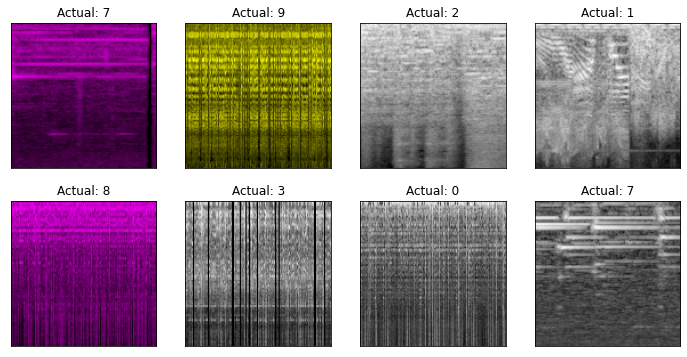

In [20]:
show_batch(ds_train, 8, 2, 4)

In [21]:
import torchvision.models as models
import torch.nn as nn
from torch.nn.functional import cross_entropy
import torchmetrics
import timm

class MusicClfLitModel(pl.LightningModule):
    def __init__(self, num_classes, hparams, model_to_use):
        super().__init__()
        self.save_hyperparameters()
        self.lr = hparams["lr"]
        self.num_classes = num_classes              
        self.backbone, self.classifier = self.get_backbone_classifier(model_to_use, hparams["drop_out"], num_classes) 

    @staticmethod
    def get_backbone_classifier(model_to_use, drop_out, num_classes):
        pt_model = timm.create_model(model_to_use, pretrained=True)
        backbone = None
        classifier = None
        if model_to_use in [Models.RESNET34, Models.RESNET50, Models.RESNEXT50]:            
            backbone = nn.Sequential(*list(pt_model.children())[:-1])
            in_features = pt_model.fc.in_features
            classifier = nn.Sequential(
                nn.Dropout(drop_out),
                nn.Linear(in_features, num_classes)
            )    
        return backbone, classifier

    def forward(self, x):
        features = self.backbone(x)
        features = torch.flatten(features, 1)                
        x = self.classifier(features)
        return x

    def configure_optimizers(self):
        model_optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, self.parameters()), lr=self.lr)
        lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(model_optimizer, "min")        
        return {
            "optimizer": model_optimizer, 
            "lr_scheduler": {
                "scheduler": lr_scheduler,
                "monitor": "val_loss",
                "frequency": 1
            }
        }

    def training_step(self, batch, batch_idx):
        id, X, y = batch
        #print(f"y.shape = {y.shape}")
        y_pred = self(X)
        #print(f"y_pred.shape = {y_pred.shape}")
        loss = cross_entropy(y_pred, y)
        #print(f"loss = {loss}")
        train_f1 = torchmetrics.functional.f1(preds=y_pred, target=y, num_classes=self.num_classes, average="micro")
        self.log("train_loss", loss, on_step=True, on_epoch=True, logger=True, prog_bar=True)
        self.log("train_f1", train_f1, on_step=True, on_epoch=True, logger=True, prog_bar=True)
        return loss        

    def validation_step(self, batch, batch_idx):
        id, X, y = batch
        y_pred = self(X)
        val_loss = cross_entropy(y_pred, y)
        val_f1 = torchmetrics.functional.f1(preds=y_pred, target=y, num_classes=self.num_classes, average="micro")
        self.log("val_loss", val_loss, on_step=True, on_epoch=True, logger=True, prog_bar=True)
        self.log("val_f1", val_f1, on_step=True, on_epoch=True, logger=True, prog_bar=True)
        return {"loss": val_loss, "val_f1": val_f1}

In [22]:
from pytorch_lightning.callbacks import ModelCheckpoint, BackboneFinetuning, EarlyStopping

# For results reproducibility 
# sets seeds for numpy, torch, python.random and PYTHONHASHSEED.
pl.seed_everything(Config.RANDOM_SEED, workers=True)

Global seed set to 42


42

In [23]:
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks import Callback

class MetricsAggCallback(Callback):
    def __init__(self, metric_to_monitor, mode):
        self.metric_to_monitor = metric_to_monitor
        self.metrics = []
        self.best_metric = None
        self.mode = mode
        self.best_metric_epoch = None

    def on_validation_epoch_end(self, trainer: Trainer, pl_module: LightningModule):
        metric_value = trainer.callback_metrics[self.metric_to_monitor].cpu().detach().item()
        val_loss = trainer.callback_metrics["val_loss"].cpu().detach().item()
        print(f"metric {self.metric_to_monitor} = {metric_value}, val_loss={val_loss}")        
        self.metrics.append(metric_value)
        if self.mode == "max":
            self.best_metric = max(self.metrics)
            self.best_metric_epoch = self.metrics.index(self.best_metric)        

In [24]:
# import wandb
# from kaggle_secrets import UserSecretsClient
# user_secrets = UserSecretsClient()
# wandb_secret = user_secrets.get_secret("wandb")
# wandb.login(key=wandb_secret)

In [25]:
from pytorch_lightning.loggers import WandbLogger

def run_training(fold, dl_train, dl_val, fold_loss, fold_f1, find_lr=True):
        fold_str = f"fold{fold}"
        print(f"Running training for {fold_str}")
        logger = None
        val_loss_chkpt = "best_model_{epoch}_{val_loss:.4f}"
        val_f1_chkpt = "best_model_{epoch}_{val_f1:.4f}"      
        multiplicative = lambda epoch: 1.5
        backbone_finetuning = BackboneFinetuning(Config.UNFREEZE_EPOCH_NO, multiplicative, verbose=True)
        early_stopping_callback = EarlyStopping(monitor="val_loss", patience=Config.PATIENCE, mode="min", verbose=True)        
        if fold is not None:       
            val_loss_chkpt = fold_str + "_" + val_loss_chkpt
            val_f1_chkpt = fold_str + "_" + val_f1_chkpt
        logger = WandbLogger(name=Config.W_AND_B_RUN_NAME, project="Pog_Music_Clf")        
        audio_model = MusicClfLitModel(
            num_classes=Config.NUM_CLASSES, 
            hparams=Config.MODEL_PARAMS,        
            model_to_use=Config.MODEL_TO_USE
        )    
        val_loss_chkpt_callback = ModelCheckpoint(dirpath="./model", verbose=True, monitor="val_loss", mode="min", filename=val_loss_chkpt)
        val_f1_chkpt_callback = ModelCheckpoint(dirpath="./model", verbose=True, monitor="val_f1", mode="max", filename=val_f1_chkpt)
        acc_chkpt_callback = MetricsAggCallback(metric_to_monitor="val_f1", mode="max")
        trainer = pl.Trainer(
            gpus=1,
            # For results reproducibility 
            deterministic=True,
            auto_select_gpus=True,
            progress_bar_refresh_rate=20,
            max_epochs=Config.NUM_EPOCHS,
            logger=logger,
            auto_lr_find=True,    
            precision=Config.PRECISION,    
            weights_summary=None, 
            fast_dev_run=Config.FAST_DEV_RUN,                   
            callbacks=[val_loss_chkpt_callback, val_f1_chkpt_callback, acc_chkpt_callback, backbone_finetuning, early_stopping_callback]
        )
        if find_lr:
            trainer.tune(model=audio_model, train_dataloaders=dl_train)
            print(audio_model.lr)
        trainer.fit(audio_model, train_dataloaders=dl_train, val_dataloaders=dl_val)                
        if not Config.FAST_DEV_RUN:
            fold_loss.append((val_loss_chkpt_callback.best_model_score.cpu().detach().item(), val_loss_chkpt_callback.best_model_path))
            fold_f1.append((acc_chkpt_callback.best_metric, val_f1_chkpt_callback.best_model_path))
            print(f"Loss for {fold_str} = {fold_loss[fold]}, f1 = {fold_f1[fold]}")
        del trainer, audio_model, backbone_finetuning, early_stopping_callback, acc_chkpt_callback, val_loss_chkpt_callback, val_f1_chkpt_callback 

In [26]:
from tqdm.notebook import tqdm

# For a specific fold get the predictions on oof (validation) data. We do this for each fold
# We then use these oof predictions to calculate the cross validation score (using the evaluation metric)
def get_oof_preds(fold, fold_loss, dl_val):
    # get the best model (having lowest val loss) for the fold
    best_model_path_val_loss = fold_loss[fold][1]
    print(f"Using best model = {best_model_path_val_loss} for oof prediction on fold {fold} validation set")
    best_model = MusicClfLitModel.load_from_checkpoint(
        checkpoint_path=best_model_path_val_loss,
        num_classes=Config.NUM_CLASSES, 
        num_mfcc=Config.NUM_MFCC, 
        hparams=Config.MODEL_PARAMS
    )
    if "val_preds" not in df_train.columns:
        df_train["val_preds"] = len(df_train) * [-100]
    with torch.no_grad():        
        for id, X, y in tqdm(dl_val):
            id = id.cpu().detach().numpy()            
            y_preds = torch.argmax(best_model(X), dim=1)
            y_preds = y_preds.cpu().detach().numpy().astype(int)            
            df_train.loc[df_train.song_id.isin(id), "val_preds"] = y_preds

In [27]:
import statistics

def print_exp_statistics(fold_loss, fold_acc):
    print("val loss across folds")
    print(fold_loss)
    print("val f1 across folds")
    print(fold_acc)
    #mean_loss = statistics.mean(fold_loss)
    #mean_acc = statistics.mean(fold_acc)
    #std_loss = statistics.stdev(fold_loss)
    #std_acc = statistics.stdev(fold_acc)
    #print(f"mean loss across folds = {mean_loss}, loss stdev across fold = {std_loss}")
    #print(f"mean accuracy across folds = {mean_acc}, accuracy stdev across fold = {std_acc}")

In [28]:
from IPython.display import display

find_lr = True
fold_loss = []
fold_f1 = []
for fold in range(Config.NUM_FOLDS):
    dl_train, dl_val, ds_train, ds_val = get_fold_dls(fold, df_train)
    run_training(fold, dl_train, dl_val, fold_loss, fold_f1, find_lr)        
    get_oof_preds(fold, fold_loss, dl_val)
    display(df_train[df_train.kfold == fold].head())
    break  

print_exp_statistics(fold_loss, fold_f1)       

Running training for fold0


Using native 16bit precision.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Running in fast_dev_run mode: will run a full train, val, test and prediction loop using 1 batch(es).
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


0.00036


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [ ]:
from sklearn.metrics import f1_score

# export the oof predictions to csv for later use in stacking
df_train.to_csv(Config.DATA_ROOT_FOLDER + "df_train_oof_preds.csv")
df_oof = df_train[df_train.val_preds != -100]
cv_f1 = f1_score(y_pred=df_oof.val_preds, y_true=df_oof.genre_id, average="micro")
print(f"Cross validation F1 score across {len(fold_loss)} folds = {cv_f1}")

In [ ]:
df_train[df_train.genre_id < 0]